In [1]:
"""
En este paso filtramos el dataset de alumnos por el año 2016 y hacemos join con el dataset de escuelas.
Luego eliminamos NULLs y grabamos el file df_final.csv. Pensando en predecir el campo nivel_desemp_matematica, 
lo transofrmamos en dos categorias, SATIFACTORIO con valor 0 (satifactorio y avanzado) y 1 BÁSICO (básico y por debajo de básico).
Para ejecutar este paso deben tener en la carpeta /desafio3/datasets , los datasets app_alumno.csv y app_escuela.csv.
"""

import pandas as pd
df = pd.read_csv('../desafio3/datasets/app_alumno.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_escuelas = pd.read_csv('../desafio3/datasets/app_escuela.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_escuelas = df_escuelas.drop('icse', axis=1)
df_provincia = pd.read_csv('../desafio3/datasets/app_provincia.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_departamento = pd.read_csv('../desafio3/datasets/app_departamento.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_salario = pd.read_csv('../desafio3/datasets/app_salario.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_gastonivel = pd.read_csv('../desafio3/datasets/app_gastonivel.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_gastoobjeto = pd.read_csv('../desafio3/datasets/app_gastoobjeto.csv', parse_dates=True, na_values=['nc'], low_memory=False)


In [2]:
#Nos quedamos con los casos sin nulos en desmpeño de matemática.
#También nos quedamos con el año 2016 y los exámenes de primaria
df = df[(df['nivel_desemp_matematica'].notnull()) & (df['year_id'] == 2016) & (df['nivel_id'] == 2)]

In [3]:
#Identificamos como avanzado y satisfactorio el desmpeño en matematica segun la nota
df['nivel_desemp_matematica'] = df['nivel_desemp_matematica'].apply(lambda x: 0 if x in ['satisfactorio','avanzado'] else 1)

In [4]:
#Eliminamos columnas que no vamos a usar en el modelo y aquellas observaciones que tengan na
df = df.drop(['id','repeticion_secundaria','nivel_desemp_ciencias_sociales','nivel_desemp_ciencias_naturales','year_id', 'nivel_id'], axis=1)
df = df.dropna(axis=0)

In [5]:
#### SE AGREGA JOIN PARA AGREGAR AL DATAFRAME LA CANTIDAD DE ALUMNOS QUE TIENE CADA ESCUELA
df_curso = pd.read_csv('../desafio3/datasets/app_curso.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_curso = df_curso[df_curso['year_id'] == 2016]
df_curso_gr = df_curso.groupby(by='escuela_id')['matricula'].sum()
df_curso_gr = df_curso_gr.reset_index()
df_escuelas = df_escuelas.rename(columns={'id': 'escuela_id'})
df_escuelas = df_escuelas.merge(df_curso_gr, how='inner', on ='escuela_id')
####

In [6]:
df = df.merge(df_escuelas, how='inner', on ='escuela_id')
df = df.drop('icse_cat', axis=1)
df = df.dropna(axis=0)

In [7]:
df_curso_prov = df_curso.merge(df_escuelas, how = 'left', on ='escuela_id')

In [8]:
df_curso_prov = df_curso_prov.groupby(by='provincia_id')['matricula_x'].sum()

In [9]:
df_curso_prov = pd.DataFrame(df_curso_prov)
df_curso_prov['id'] = df_curso_prov.index


In [10]:
# Limpieza del dataset de salario
df_salario = df_salario[(df_salario['year_id'] == 2016)]
df_salario = df_salario.groupby(['provincia_id', 'name'])['value'].aggregate('mean').unstack()


In [11]:
# Limpieza del dataset de gasto nivel
df_gastonivel = df_gastonivel[(df_gastonivel['year_id'] == 2016)]
df_gastonivel = df_gastonivel.groupby(['provincia_id', 'name'])['value'].aggregate('mean').unstack()
df_gastonivel = df_gastonivel.merge(df_curso_prov, how='inner', left_on=['provincia_id'],right_on=['id'])
df_gastonivel = df_gastonivel[['inicial+primaria', 'privada', 'secundaria', 'sin_discriminar', 'snu']].div(df_gastonivel.matricula_x, axis=0)
df_gastonivel['provincia_id'] = df_gastonivel.index

In [12]:
# Limpieza del dataset de gasto objeto
df_gastoobjeto = df_gastoobjeto[(df_gastoobjeto['year_id'] == 2016)]
df_gastoobjeto = df_gastoobjeto.groupby(['provincia_id', 'name'])['value'].aggregate('mean').unstack()
df_gastoobjeto = df_gastoobjeto.merge(df_curso_prov, how='inner', left_on=['provincia_id'],right_on=['id'])
df_gastoobjeto = df_gastoobjeto[['bienes_y_servicios_no_personales', 'erogacion_de_capital', 'personal', 'transferencias_educacion_privada', 'transferencias_otras']].div(df_gastoobjeto.matricula_x, axis=0)
df_gastoobjeto['provincia_id'] = df_gastoobjeto.index

In [13]:
# Merge de los dataset limpios

df = df.merge(df_salario, how = 'inner', on = 'provincia_id')
df = df.merge(df_gastonivel, how = 'inner', on = 'provincia_id')
df = df.merge(df_gastoobjeto, how = 'inner', on = 'provincia_id')

In [14]:
ponderador_mate = df.ponderador_matematica
ponderador_lengua = df.ponderador_lengua
df.drop(columns=['ponderador_lengua', 'ponderador_matematica','ponderador_ciencias_naturales', 'ponderador_ciencias_sociales'],inplace = True)
df_ponderadores = pd.concat([ponderador_mate, ponderador_lengua], axis=1)

In [15]:
print('#######SHAPE:','\n',df.shape,'\n','#######','\n')
print('#######VALUE_COUNTS:','\n',df['nivel_desemp_matematica'].value_counts(),'\n','#######','\n')
print('#######NULLs:','\n',(df.isnull().sum()/df.shape[0])*100,'\n','#######','\n')
print('#######BALANCE:','\n',df['nivel_desemp_matematica'].value_counts(),'\n','#######','\n')
df.to_csv('../desafio3/datasets/df_final.csv')
df_ponderadores.to_csv('../desafio3/datasets/df_ponderadores.csv')

#######SHAPE: 
 (277573, 42) 
 ####### 

#######VALUE_COUNTS: 
 0    170447
1    107126
Name: nivel_desemp_matematica, dtype: int64 
 ####### 

#######NULLs: 
 sexo                                0.0
indice_socioeconomico               0.0
nivel_desemp_matematica             0.0
nivel_desemp_lengua                 0.0
tiene_notebook                      0.0
tiene_pc                            0.0
tiene_tablet                        0.0
tiene_celular                       0.0
tiene_smartphone                    0.0
tiene_consola                       0.0
tiene_smarttv                       0.0
tiene_cable                         0.0
tiene_internet_x                    0.0
repeticion_primaria                 0.0
escuela_id                          0.0
ambito                              0.0
gestion                             0.0
indice_socioeconomico_medio         0.0
indice_socioeconomico_medio_cat     0.0
tecnica                             0.0
tiene_internet_y                    0.0


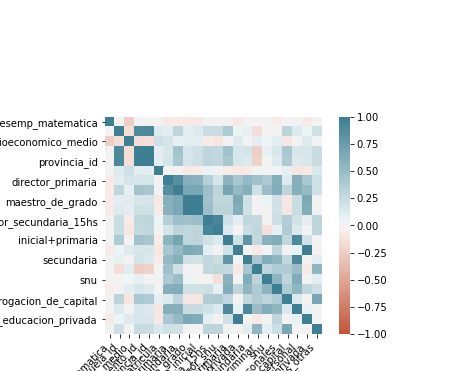

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);